In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import logging
import pandas as pd
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis
from insightface.utils import face_align
import random
import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns


/Users/samir/miniforge3/envs/kinship_recognition/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Initialize FaceAnalysis
def initialize_face_analysis():
    app = FaceAnalysis(name='buffalo_l')
    app.prepare(ctx_id=0, det_size=(128, 128))
    return app

app = initialize_face_analysis()
print("FaceAnalysis model initialized.")

/Users/samir/miniforge3/envs/kinship_recognition/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

In [3]:
# Define paths
INPUT_ROOT = '../data/raw/fiw/train/train-faces'
OUTPUT_ROOT = '../data/processed/fiw/train/train-faces'
SAVE_PATH = '../data/processed/fiw/train'
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# Set up logging
logging.basicConfig(
    filename='preprocessing.log',
    filemode='a',
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

In [4]:
# Function to load mid.csv
def load_mid_csv(family_path):
    mid_csv_path = os.path.join(family_path, 'mid.csv')
    if not os.path.exists(mid_csv_path):
        logging.warning(f"mid.csv not found for family: {family_path}")
        return None
    
    mid_df = pd.read_csv(mid_csv_path)
    relationship_matrix = mid_df.iloc[:, 1:8].values
    mid_df['relationships'] = [relationship_matrix[i].tolist() for i in range(len(mid_df))]
    return mid_df

# Function to process image
def process_image(app, image_path, output_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            logging.warning(f"Failed to load image: {image_path}")
            return None
        
        faces = app.get(img)
        if not faces:
            logging.warning(f"No face detected in image: {image_path}")
            return None
        
        face = faces[0]
        kps = face.kps.astype(int)
        aligned_face = face_align.norm_crop(img, kps)
        if aligned_face is None:
            logging.warning(f"Failed to align face in image: {image_path}")
            return None
        
        cv2.imwrite(output_path, aligned_face)
        
        family = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
        member = os.path.basename(os.path.dirname(image_path))
        image_name = os.path.basename(image_path)
        metadata = {
            'Family': family,
            'Member': member,
            'Original_Image_Name': image_name,
            'Aligned_Image_Path': output_path,
            'Detection_Score': face.det_score,
            'Age': face.age,
            'Detected_Gender': face.sex
        }
        
        return metadata
    except Exception as e:
        logging.error(f"Error processing image {image_path}: {e}")
        return None

# Function to process all images
def process_all_images(input_root, output_root, app):
    metadata_list = []
    families = [d for d in os.listdir(input_root) if os.path.isdir(os.path.join(input_root, d))]
    families.sort()
    
    for family in tqdm(families, desc="Processing families"):
        family_path = os.path.join(input_root, family)
        output_family_path = os.path.join(output_root, family)
        os.makedirs(output_family_path, exist_ok=True)
        
        mid_df = load_mid_csv(family_path)
        
        members = [d for d in os.listdir(family_path) if os.path.isdir(os.path.join(family_path, d))]
        
        for member in members:
            member_path = os.path.join(family_path, member)
            output_member_path = os.path.join(output_family_path, member)
            os.makedirs(output_member_path, exist_ok=True)
            
            images = [f for f in os.listdir(member_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            
            for image_name in images:
                image_path = os.path.join(member_path, image_name)
                output_image_path = os.path.join(output_member_path, image_name)
                
                metadata = process_image(app, image_path, output_image_path)
                
                if metadata:
                    if mid_df is not None and member != 'unrelated_and_nonfaces':
                        try:
                            mid_info = mid_df[mid_df['MID'] == int(member[3:])].iloc[0]
                            metadata['Name'] = mid_info['Name']
                            metadata['True_Gender'] = mid_info['Gender']
                            metadata['Relationships'] = mid_info['relationships']
                        except (ValueError, IndexError):
                            logging.warning(f"Could not find MID info for member: {member}")
                            metadata['Name'] = 'Unknown'
                            metadata['True_Gender'] = 'Unknown'
                            metadata['Relationships'] = []
                    else:
                        metadata['Name'] = 'Unknown'
                        metadata['True_Gender'] = 'Unknown'
                        metadata['Relationships'] = []
                    
                    metadata_list.append(metadata)
                else:
                    logging.warning(f"Failed to process image: {image_path}")
    
    return metadata_list

In [5]:
# Process all images and collect metadata
metadata_list = process_all_images(INPUT_ROOT, OUTPUT_ROOT, app)

Processing families:   0%|          | 0/571 [00:00<?, ?it/s]/Users/samir/miniforge3/envs/kinship_recognition/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
Processing families:   0%|          | 1/571 [00:04<43:39,  4.60s/it]/Users/samir/miniforge3/envs/kinship_recognition/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq

In [6]:
# Convert metadata list to DataFrame
metadata_df = pd.DataFrame(metadata_list)

# Save metadata to CSV
CSV_PATH = os.path.join('../data/processed/fiw/train', 'fiw_metadata.csv')
metadata_df.to_csv(CSV_PATH, index=False)
print(f"Metadata saved to {CSV_PATH}")

Metadata saved to ../data/processed/fiw/train/fiw_metadata.csv


Entries with unknown True Gender (excluding unrelated_and_nonfaces):
      Family Member True_Gender Detected_Gender True_Gender_Std  \
11759  F0601  MID45     Unknown               M         unknown   
11760  F0601  MID45     Unknown               M         unknown   
11761  F0601  MID45     Unknown               M         unknown   
11914  F0601  MID44     Unknown               M         unknown   
11915  F0601  MID44     Unknown               M         unknown   
11916  F0601  MID44     Unknown               M         unknown   
11917  F0601  MID43     Unknown               F         unknown   
11918  F0601  MID43     Unknown               F         unknown   
11919  F0601  MID43     Unknown               F         unknown   
11920  F0601  MID43     Unknown               F         unknown   
11921  F0601  MID43     Unknown               F         unknown   
11922  F0601  MID43     Unknown               F         unknown   
11923  F0601  MID43     Unknown               F         unkn

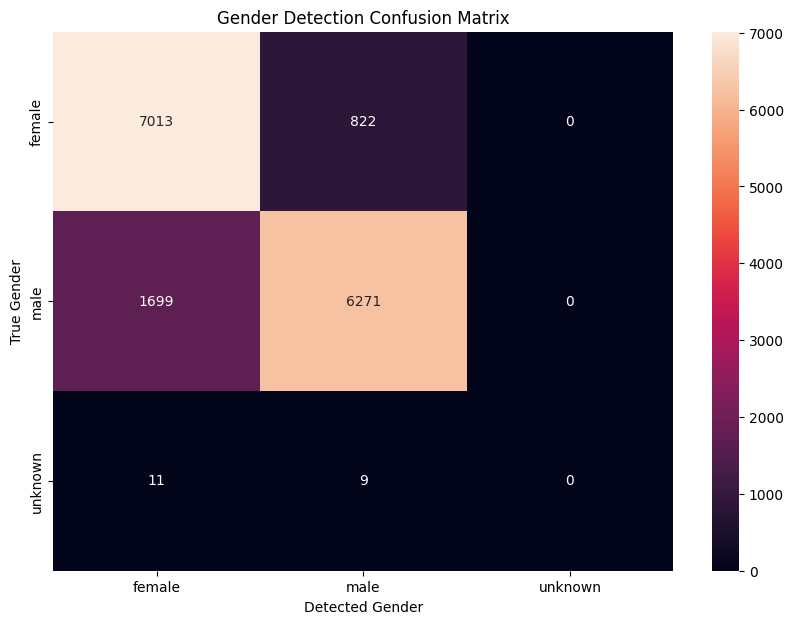


Detailed Analysis:
True: female, Detected: female - Count: 7013
True: female, Detected: male - Count: 822
True: female, Detected: unknown - Count: 0
True: male, Detected: female - Count: 1699
True: male, Detected: male - Count: 6271
True: male, Detected: unknown - Count: 0
True: unknown, Detected: female - Count: 11
True: unknown, Detected: male - Count: 9
True: unknown, Detected: unknown - Count: 0

Gender detection accuracy (excluding unknown true genders): 84.05%

Gender distribution in the dataset:
True_Gender_Std
male       0.503633
female     0.495103
unknown    0.001264
Name: proportion, dtype: float64

Accuracy for each gender:
Male: 78.68%
Female: 89.51%


In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to standardize gender representation
def standardize_gender(gender):
    if isinstance(gender, str):
        if gender.lower() in ['m', 'male']:
            return 'male'
        elif gender.lower() in ['f', 'female']:
            return 'female'
    return 'unknown'

# Create a new DataFrame for analysis, excluding 'unrelated_and_nonfaces'
analysis_df = metadata_df[~metadata_df['Member'].str.contains('unrelated_and_nonfaces', case=False, na=False)].copy()

# Apply standardization to both Detected_Gender and True_Gender
analysis_df['Detected_Gender_Std'] = analysis_df['Detected_Gender'].apply(standardize_gender)
analysis_df['True_Gender_Std'] = analysis_df['True_Gender'].apply(standardize_gender)

# Find entries where True_Gender_Std is 'unknown'
unknown_true_gender = analysis_df[analysis_df['True_Gender_Std'] == 'unknown']

print("Entries with unknown True Gender (excluding unrelated_and_nonfaces):")
if unknown_true_gender.empty:
    print("No unknown true genders found in family member data.")
else:
    print(unknown_true_gender[['Family', 'Member', 'True_Gender', 'Detected_Gender', 'True_Gender_Std', 'Detected_Gender_Std']])

# Find entries where Detected_Gender_Std is 'unknown'
unknown_detected_gender = analysis_df[analysis_df['Detected_Gender_Std'] == 'unknown']

print("\nEntries with unknown Detected Gender (excluding unrelated_and_nonfaces):")
if unknown_detected_gender.empty:
    print("No unknown detected genders found in family member data.")
else:
    print(unknown_detected_gender[['Family', 'Member', 'True_Gender', 'Detected_Gender', 'True_Gender_Std', 'Detected_Gender_Std']])

# Print the total counts
print(f"\nTotal entries with unknown True Gender: {len(unknown_true_gender)}")
print(f"Total entries with unknown Detected Gender: {len(unknown_detected_gender)}")

# Print unique families and members with unknown genders
print("\nUnique families with unknown genders:")
unique_families = unknown_true_gender['Family'].unique()
print([str(family) for family in unique_families])

print("\nUnique members with unknown genders:")
unique_members = unknown_true_gender['Member'].unique()
print([str(member) for member in unique_members])

# Calculate accuracy
gender_accuracy = accuracy_score(analysis_df['True_Gender_Std'], analysis_df['Detected_Gender_Std'])
print(f"\nGender detection accuracy: {gender_accuracy:.2%}")

# Create confusion matrix
conf_matrix = confusion_matrix(analysis_df['True_Gender_Std'], analysis_df['Detected_Gender_Std'], labels=['female', 'male', 'unknown'])

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', 
            xticklabels=['female', 'male', 'unknown'], 
            yticklabels=['female', 'male', 'unknown'])
plt.xlabel('Detected Gender')
plt.ylabel('True Gender')
plt.title('Gender Detection Confusion Matrix')
plt.show()

# Detailed analysis
print("\nDetailed Analysis:")
for true_gender in ['female', 'male', 'unknown']:
    for detected_gender in ['female', 'male', 'unknown']:
        count = ((analysis_df['True_Gender_Std'] == true_gender) & (analysis_df['Detected_Gender_Std'] == detected_gender)).sum()
        print(f"True: {true_gender}, Detected: {detected_gender} - Count: {count}")

# Additional analysis: Gender detection accuracy excluding unknown true genders
known_gender_df = analysis_df[analysis_df['True_Gender_Std'] != 'unknown']
known_gender_accuracy = accuracy_score(known_gender_df['True_Gender_Std'], known_gender_df['Detected_Gender_Std'])
print(f"\nGender detection accuracy (excluding unknown true genders): {known_gender_accuracy:.2%}")

# Gender distribution in the dataset
print("\nGender distribution in the dataset:")
print(analysis_df['True_Gender_Std'].value_counts(normalize=True))

# Check for any bias in gender detection
print("\nAccuracy for each gender:")
for gender in ['male', 'female']:
    gender_subset = analysis_df[analysis_df['True_Gender_Std'] == gender]
    gender_accuracy = accuracy_score(gender_subset['True_Gender_Std'], gender_subset['Detected_Gender_Std'])
    print(f"{gender.capitalize()}: {gender_accuracy:.2%}")

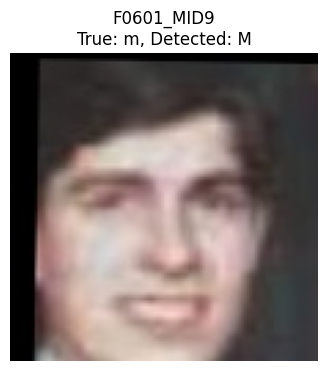

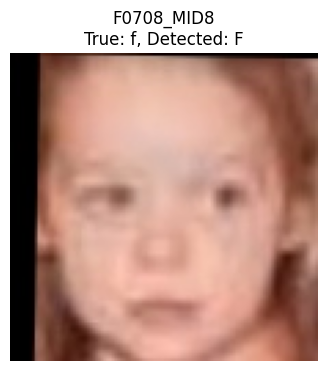

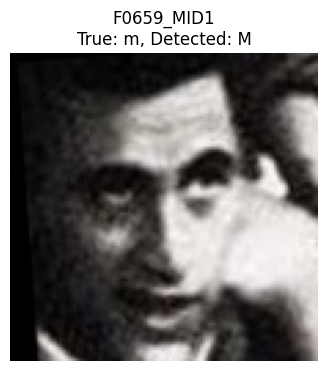

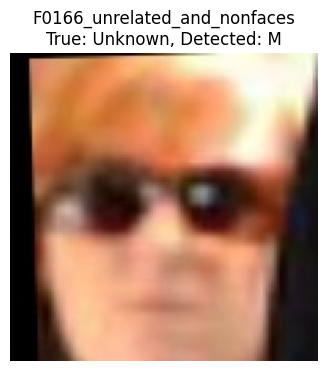

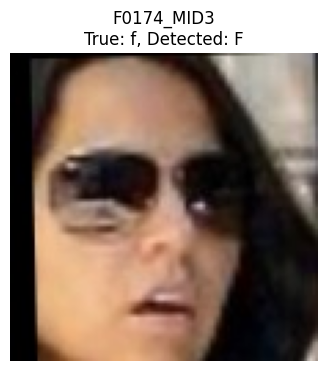

In [17]:
# Visualize the aligned faces
def visualize_faces(metadata_df, num_faces=5):
    for i in range(num_faces):
        i = np.random.randint(len(metadata_df))
        metadata = metadata_df.iloc[i]
        img = cv2.imread(metadata['Aligned_Image_Path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"{metadata['Family']}_{metadata['Member']}\nTrue: {metadata['True_Gender']}, Detected: {metadata['Detected_Gender']}")
        plt.axis('off')
        plt.show()

visualize_faces(metadata_df)

In [11]:
# Load and process train-pairs.csv
PAIR_CSV_PATH = os.path.join('../data/raw/fiw/train/', 'train-pairs.csv')
pairs_df = pd.read_csv(PAIR_CSV_PATH)
print("Columns in pairs_df:", pairs_df.columns.tolist())
print(pairs_df.head())

def get_aligned_images(member_identifier, processed_root):
    family, member = member_identifier.split('/')
    member_dir = os.path.join(processed_root, family, member)
    if not os.path.exists(member_dir):
        logging.warning(f"Member directory does not exist: {member_dir}")
        return []
    
    aligned_images = glob.glob(os.path.join(member_dir, '*.jpg')) + \
                     glob.glob(os.path.join(member_dir, '*.png')) + \
                     glob.glob(os.path.join(member_dir, '*.jpeg'))
    return aligned_images

def gather_all_unrelated_images(processed_root):
    unrelated_images = []
    families = [d for d in os.listdir(processed_root) if os.path.isdir(os.path.join(processed_root, d))]
    for family in families:
        unrelated_dir = os.path.join(processed_root, family, 'unrelated_and_nonfaces')
        if os.path.exists(unrelated_dir):
            images = glob.glob(os.path.join(unrelated_dir, '*.jpg')) + \
                     glob.glob(os.path.join(unrelated_dir, '*.png')) + \
                     glob.glob(os.path.join(unrelated_dir, '*.jpeg'))
            unrelated_images.extend(images)
        else:
            logging.warning(f"'unrelated_and_nonfaces' directory not found for family: {family}")
    return unrelated_images

all_unrelated_images = gather_all_unrelated_images(OUTPUT_ROOT)
print(f"Total unrelated images collected: {len(all_unrelated_images)}")

Columns in pairs_df: ['p1', 'p2', 'ptype', 'fid1', 'fid2', 'tags', 'set', 'nsamples']
           p1          p2 ptype   fid1   fid2  tags  set  nsamples
0  F0001/MID1  F0001/MID3    fs  F0001  F0001     0    0         6
1  F0001/MID1  F0001/MID4    fs  F0001  F0001     0    0        18
2  F0001/MID2  F0001/MID4    ms  F0001  F0001     0    0        15
3  F0001/MID2  F0001/MID3    ms  F0001  F0001     0    0         5
4  F0001/MID3  F0001/MID4    ss  F0001  F0001     0    0         3
Total unrelated images collected: 4517


In [12]:
def generate_triplets(pairs_df, processed_root, unrelated_images):
    triplets = []
    
    required_columns = ['p1', 'p2', 'nsamples', 'ptype']
    for col in required_columns:
        if col not in pairs_df.columns:
            raise KeyError(f"Column '{col}' not found in pairs_df. Available columns: {pairs_df.columns.tolist()}")
    
    for idx, row in tqdm(pairs_df.iterrows(), total=pairs_df.shape[0], desc="Generating triplets"):
        p1 = row['p1']
        p2 = row['p2']
        nsamples = row['nsamples']
        ptype = row['ptype']
        
        if not isinstance(nsamples, (int, float)) or nsamples < 1:
            logging.warning(f"Invalid nsamples value at row {idx}: {nsamples}. Skipping this pair.")
            continue
        
        p1_images = get_aligned_images(p1, processed_root)
        p2_images = get_aligned_images(p2, processed_root)
        
        if len(p1_images) == 0:
            logging.warning(f"No images found for p1: {p1}. Skipping this pair.")
            continue
        if len(p2_images) == 0:
            logging.warning(f"No images found for p2: {p2}. Skipping this pair.")
            continue
        
        for _ in range(int(nsamples)):
            anchor = random.choice(p1_images)
            positive = random.choice(p2_images)
            negative = random.choice(unrelated_images)
            triplets.append((anchor, positive, negative, ptype))
    
    return triplets

# Generate triplets with labels
try:
    triplets = generate_triplets(pairs_df, OUTPUT_ROOT, all_unrelated_images)
    print(f"Total triplets generated: {len(triplets)}")
except KeyError as e:
    print(f"KeyError encountered: {e}")


Generating triplets:   0%|          | 0/6983 [00:00<?, ?it/s]

Generating triplets: 100%|██████████| 6983/6983 [00:01<00:00, 3768.96it/s]

Total triplets generated: 264540


In [13]:
# Save triplets to CSV
TRIPLET_CSV_PATH = os.path.join(OUTPUT_ROOT, 'triplets_with_labels.csv')
triplet_df = pd.DataFrame(triplets, columns=['Anchor', 'Positive', 'Negative', 'ptype'])
triplet_df['Triplet_ID'] = triplet_df.index + 1
triplet_df = triplet_df[['Triplet_ID', 'Anchor', 'Positive', 'Negative', 'ptype']]
triplet_df.to_csv(TRIPLET_CSV_PATH, index=False)

print(f"Triplets with labels saved to {TRIPLET_CSV_PATH}")
print("Preprocessing completed successfully!")

Triplets with labels saved to ../data/processed/fiw/train/train-faces/triplets_with_labels.csv
Preprocessing completed successfully!
